This model will read data from a large set and Classify the Sentiment:
Positive, Negative, Natural

In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
data = pd.read_csv('swiggy.csv')
data.head()


,ID,Area,City,Restaurant Price,Avg Rating,Total Rating,Food Item,Food Type,Delivery Time,Review
0,1,Suburb,Ahmedabad,600,4.2,6198,Sushi,Fast Food,30-40 min,"Good, but nothing extraordinary."
1,2,Business District,Pune,200,4.7,4865,Pepperoni Pizza,Non-Vegetarian,50-60 min,"Good, but nothing extraordinary."
2,3,Suburb,Bangalore,600,4.7,2095,Waffles,Fast Food,50-60 min,Late delivery ruined it.
3,4,Business District,Mumbai,900,4.0,6639,Sushi,Vegetarian,50-60 min,Best meal I've had in a while!
4,5,Tech Park,Mumbai,200,4.7,6926,Spring Rolls,Gluten-Free,20-30 min,Mediocre experience.


In [4]:
# Small code snippet for Tokenizer:

sentences = [
    'I am a good Boy', 
    'This is a good desk',
    'Boy is roaming around'
]

# Build vocab from the text data:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(sentences)

# View the word index (Vocab index)
word_index = tokenizer.word_index
word_index

# Convert orignal text to sequence
text_to_sequence = tokenizer.texts_to_sequences(sentences)
text_to_sequence

# pad_sequences: This function ensures that all sequences in a list have the same length, 
# which is a requirement for feeding data into a neural network.
padded_sequence = pad_sequences(text_to_sequence, padding = 'post')
padded_sequence


array([[ 5,  6,  1,  2,  3],
       [ 7,  4,  1,  2,  8],
       [ 3,  4,  9, 10,  0]], dtype=int32)

In [2]:
data = pd.read_csv('swiggy.csv')
data.head()

,ID,Area,City,Restaurant Price,Avg Rating,Total Rating,Food Item,Food Type,Delivery Time,Review
0,1,Suburb,Ahmedabad,600,4.2,6198,Sushi,Fast Food,30-40 min,"Good, but nothing extraordinary."
1,2,Business District,Pune,200,4.7,4865,Pepperoni Pizza,Non-Vegetarian,50-60 min,"Good, but nothing extraordinary."
2,3,Suburb,Bangalore,600,4.7,2095,Waffles,Fast Food,50-60 min,Late delivery ruined it.
3,4,Business District,Mumbai,900,4.0,6639,Sushi,Vegetarian,50-60 min,Best meal I've had in a while!
4,5,Tech Park,Mumbai,200,4.7,6926,Spring Rolls,Gluten-Free,20-30 min,Mediocre experience.


In [4]:
# Data Preprocessing:

data.shape
# (8000, 11)
# Drop the null rows:
data= data.dropna()
data.shape

# Cleaning and sentiment labeling:

data['Review'] = data['Review'].str.lower()
data['Review']

# good, but nothing extraordinary.
# Data still has many non-needed values we need to clear it:

data['Review'] = data['Review'].replace(r'[^a-z0-9\s]', '', regex = True)
data['Review'] = data['Review'].str.strip()
data['Review'] = data['Review'].replace(r'\s+', ' ', regex=True)
# good but nothing extraordinary

# Sentiment col adding 1 for > 3.5 and 0 otherwise
data['Sentiment'] = data['Avg Rating'].apply(lambda x: 1 if x > 3.5 else 0)
data['Sentiment']



# Check class distribution
print("\nClass distribution:")
print(data['Sentiment'].value_counts())
print(f"Class balance: {data['Sentiment'].value_counts(normalize=True)}")

# Remove empty reviews after cleaning
data = data[data['Review'].str.len() > 0]
print(f"\nFinal data shape: {data.shape}")



Class distribution:
Sentiment
1    5727
0    2273
Name: count, dtype: int64
Class balance: Sentiment
1    0.715875
0    0.284125
Name: proportion, dtype: float64

Final data shape: (8000, 11)


In [5]:
# Tokenize and pad the review data and extract the target sentiment:
# Tokenize: Converts text data to integer sequences
# Padding: Ensures all input sequences have the same length


max_features = 5000 #Sets the maximum number of words to keep in the tokenizer
max_length = 200 # Defines the fixed length for each input sequence after padding

# Initialize tokenizer with oov_token for unknown words

tokenizer = Tokenizer(num_words= max_features , oov_token='<OOV>')
tokenizer.fit_on_texts(data['Review'])
text_to_sequence= tokenizer.texts_to_sequences(data['Review'])


# [47, 10, 11, 48],
#  [47, 10, 11, 48],
#  [71, 9, 72, 3],

# Pad sequences (pre-padding by default, which is better for RNNs)
X = pad_sequences(text_to_sequence, maxlen=max_length, padding='pre', truncating='pre')
y = data['Sentiment'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Sample sequence length: {len(text_to_sequence[0])}")

X shape: (8000, 200)
y shape: (8000,)
Vocabulary size: 73
Sample sequence length: 4


In [8]:
# Splitting the data: Training, validation and test sets
# While mainting the class distribution

In [6]:
# The stratify parameter in scikit-learn's train_test_split function ensures that the resulting training and testing sets maintain 
# the same proportion of samples for each class as in the original dataset. 


# train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) : Splits data into 80% training and 20% test sets, preserving sentiment class balance
# train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train) : Further splits training data into 90% training and 10% validation sets, keeping class distribution consistent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42, stratify=y_train)

In [10]:
# RNN Modeling:
# 1. Architecting Model
# 2. Compile Model
# 3. Train Model
# 4. Evaluate Model
# 5. Test Model

In [7]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(output_dim = 128, input_dim=max_features, input_length = max_length))
# LSTM layer: Better than SimpleRNN for capturing long-term dependencies
# Dropout for regularization to prevent overfitting

model.add(tf.keras.layers.LSTM(units = 128, dropout = 0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(tf.keras.layers.Dense(units= 64, activation= 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

c:\Users\thedo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

# Compile model with improved optimizer settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']  # Additional metrics for better evaluation
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks= [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True,
        verbose = 1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor=0.5,  # Reduce learning rate by half
        patience=2,
        min_lr=0.0001,
        verbose=1
    )
]

In [10]:
history= model.fit(X_train, y_train, epochs= 10, validation_data = (X_val, y_val), batch_size = 32,
    callbacks=callbacks,verbose = 1)

score = model.evaluate(X_test,y_test, verbose=0)

print(f'Test Accuracy: {score[1]:.2f}')

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 418ms/step - accuracy: 0.7155 - loss: 0.6063 - precision: 0.7164 - recall: 0.9976 - val_accuracy: 0.7156 - val_loss: 0.6061 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 389ms/step - accuracy: 0.7160 - loss: 0.6008 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.5988 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 437ms/step - accuracy: 0.7160 - loss: 0.6001 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.5972 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - accuracy: 0.7160 - loss: 0.6008 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.5993 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 453ms/st

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       455
    Positive       0.72      1.00      0.83      1145

    accuracy                           0.72      1600
   macro avg       0.36      0.50      0.42      1600
weighted avg       0.51      0.72      0.60      1600


Confusion Matrix:
[[   0  455]
 [   0 1145]]


c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


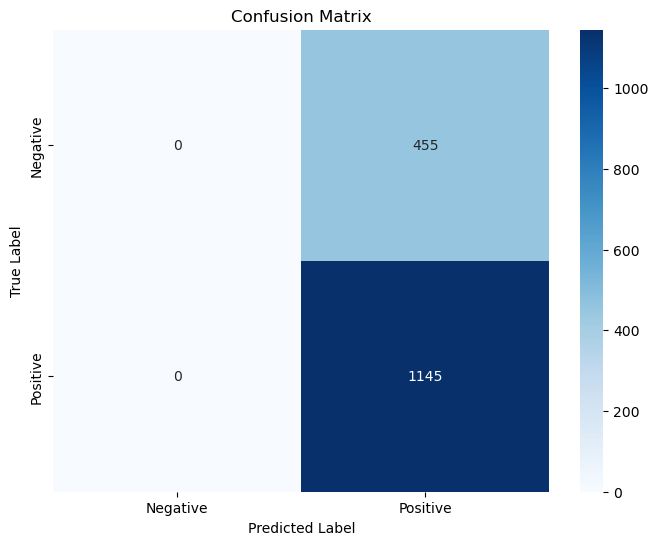

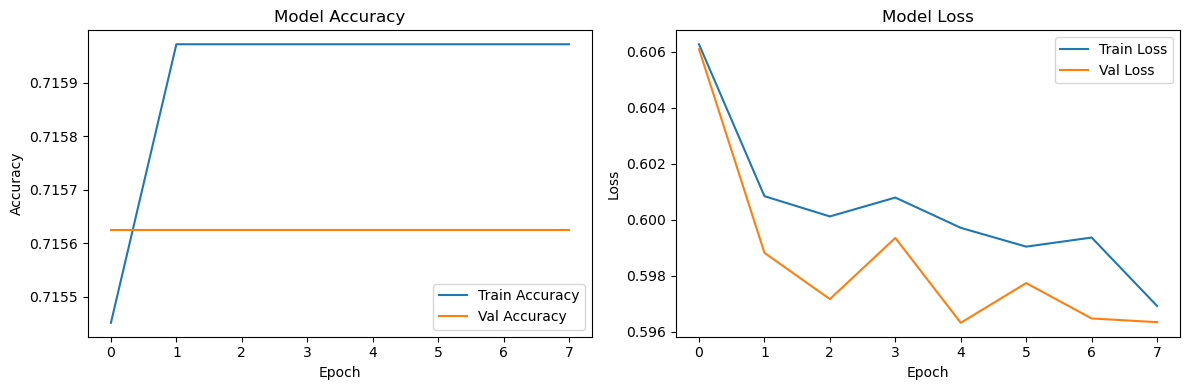

In [11]:
# Comprehensive Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Improved prediction function with better preprocessing
def make_prediction(review, model=model, tokenizer=tokenizer, max_length=max_length):
    """
    Predict sentiment for a single review.
    
    Args:
        review: String containing the review text
        model: Trained Keras model
        tokenizer: Fitted tokenizer
        max_length: Maximum sequence length
    
    Returns:
        Dictionary with sentiment label and probability
    """
    # Preprocess (same as training data)
    review_processed = review.lower()
    review_processed = re.sub(r'[^a-z0-9\s]', '', review_processed)
    review_processed = review_processed.strip()
    review_processed = re.sub(r'\s+', ' ', review_processed)
    
    # Handle empty reviews
    if len(review_processed) == 0:
        return {
            'sentiment': 'Neutral',
            'probability': 0.5,
            'message': 'Empty review after preprocessing'
        }
    
    # Tokenize
    seq = tokenizer.texts_to_sequences([review_processed])
    
    # Padding
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='pre', truncating='pre')
    
    # Predict (using model() instead of deprecated model.predict() for single samples)
    prediction_proba = model(padded_seq, training=False)[0][0].numpy()
    prediction_label = 'Positive' if prediction_proba >= 0.5 else 'Negative'
    
    return {
        'sentiment': prediction_label,
        'probability': float(prediction_proba),
        'confidence': f"{prediction_proba*100:.2f}%"
    }

# Test predictions
test_reviews = [
    'Late delivery ruined it',
    'Amazing food, great service!',
    'The food was okay, nothing special',
    'Terrible experience, will not order again'
]

print("Sentiment Predictions:")
print("-" * 60)
for review in test_reviews:
    result = make_prediction(review)
    print(f"Review: {review}")
    print(f"Sentiment: {result['sentiment']} ({result['confidence']})")
    print(f"Probability: {result['probability']:.4f}")
    print("-" * 60)

Sentiment Predictions:
------------------------------------------------------------
Review: Late delivery ruined it
Sentiment: Positive (68.88%)
Probability: 0.6888
------------------------------------------------------------
Review: Amazing food, great service!
Sentiment: Positive (70.80%)
Probability: 0.7080
------------------------------------------------------------
Review: The food was okay, nothing special
Sentiment: Positive (70.46%)
Probability: 0.7046
------------------------------------------------------------
Review: Terrible experience, will not order again
Sentiment: Positive (70.00%)
Probability: 0.7000
------------------------------------------------------------


In [12]:
# Predict sentiments: We will create a function to preprocess a single review, predict its sentiment and display the result.
def make_prediction(review):
# Preprocess
    review = review.lower()
    review = re.sub(r'[^a-z0-9\s]', '', review)

# Tokenize
    seq = tokenizer.texts_to_sequences([review])

# Padding
    padded_seq = pad_sequences(seq, maxlen = max_length)

    prediction = model.predict(padded_seq)[0][0]

    return f"{'Positive' if prediction >= 0.5 else 'Negative'} (Probability: {prediction:.2f})"


review = 'I did not like the food'

make_prediction(review)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


'Positive (Probability: 0.71)'

Short answer to your question
Yes, your results are very consistent with biased / noisy labels, not just model architecture issues.
With:
72/28 class split,
noisy label rule from ratings, and
the confusion matrix showing no predicted negatives at all,
the main bottleneck is what the model is being asked to learn from, not just how it’s learning.
If you’d like, I can walk you through exact code changes to:
clean up the label rule (e.g., 2★ and below vs 4★ and above, dropping the middle), and
optionally downsample positives to match negatives.